<a href="https://colab.research.google.com/github/lcroffi/U-NET/blob/main/TF2-4_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, concatenate, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
import itertools

### Carregando o dataset CIFAR de 10 classes do Tensorflow

In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [3]:
K = len(set(y_train))
print("número de classes:", K)

número de classes: 10


In [4]:
def conv(layer, filter, kernel):
  x = Conv2D(filter, kernel, activation='relu', padding='same')(layer)
  x = BatchNormalization()(x)
  x = Conv2D(filter, kernel, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)
  
  return x

In [5]:
def deconv(layer, conv_layer, filter, kernel):
  x = Conv2DTranspose(filter, kernel, strides = (2, 2), padding = 'same')(layer)
  x = concatenate([x, conv_layer])
  x = Dropout(0.1)(x)
  x = Conv2D(filter, kernel, activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  return x

In [53]:
def unet(x_train):
  i = Input(shape=x_train[0].shape)

  c1 = conv(i, 32, (3,3))
  c2 = conv(c1, 64, (3,3))
  c3 = conv(c2, 128, (3, 3))

  u1 = deconv(c3, c2, 64, (3, 3))
  u2 = deconv(u1, c1, 32, (3, 3))

  x = Flatten()(u2)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.8)(x)
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(K, activation='softmax')(x)

  return Model(i, x)

In [54]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.8, beta_2=0.9, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

### Configuração do modelo

In [55]:
model = unet(x_train)

model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('unet_classifier.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [56]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 32, 32, 32)   896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 32, 32, 32)   128         conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 32)   9248        batch_normalization_48[0][0]     
____________________________________________________________________________________________

### Data Augmentation

In [58]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, vertical_flip=True, horizontal_flip=True, zoom_range = 0.2)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [59]:
history = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=100, callbacks=callbacks)

Epoch 1/100
1562/1562 [==============================] - 35s 22ms/step - loss: 3.0170 - accuracy: 0.1462 - val_loss: 1.9100 - val_accuracy: 0.3298

Epoch 00001: val_loss improved from inf to 1.91005, saving model to unet_classifier.h5
Epoch 2/100
1562/1562 [==============================] - 33s 21ms/step - loss: 2.1240 - accuracy: 0.2366 - val_loss: 1.8069 - val_accuracy: 0.3432

Epoch 00002: val_loss improved from 1.91005 to 1.80689, saving model to unet_classifier.h5
Epoch 3/100
1562/1562 [==============================] - 33s 21ms/step - loss: 1.9589 - accuracy: 0.2785 - val_loss: 1.7229 - val_accuracy: 0.3700

Epoch 00003: val_loss improved from 1.80689 to 1.72289, saving model to unet_classifier.h5
Epoch 4/100
1562/1562 [==============================] - 34s 22ms/step - loss: 1.8587 - accuracy: 0.3110 - val_loss: 1.6773 - val_accuracy: 0.3836

Epoch 00004: val_loss improved from 1.72289 to 1.67729, saving model to unet_classifier.h5
Epoch 5/100
1562/1562 [=========================

### Loss

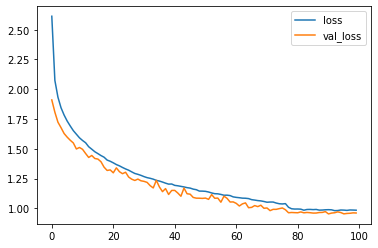

In [60]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

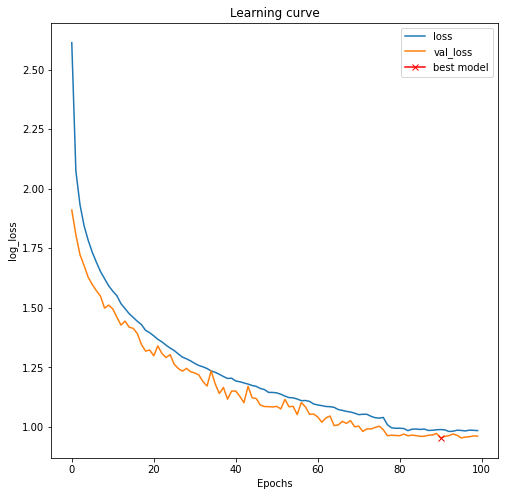

In [61]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Accuracy

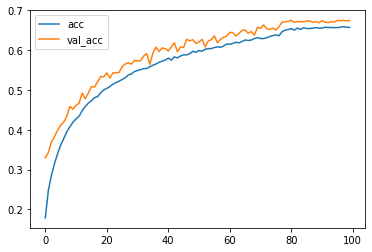

In [62]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

### Confusion Matrix

Confusion matrix, without normalization
[[732  39  48   4  15   3  25  19  69  46]
 [  9 759   1   3   1   0  23   3  14 187]
 [ 81   8 430  47  95  49 225  29  20  16]
 [ 12  18  43 421  64 101 239  49  23  30]
 [ 21   4  50  29 582  11 229  62   8   4]
 [ 10  15  20 228  52 475 122  47  14  17]
 [  4   3  11  26   8   5 933   1   9   0]
 [ 19   3  16  51  93  38  47 710   7  16]
 [ 56  40   5   4   9   0  17   1 823  45]
 [ 14  50   2   6   3   0  16   9  17 883]]


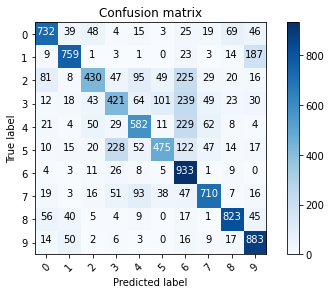

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, p_test))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1000
           1       0.81      0.76      0.78      1000
           2       0.69      0.43      0.53      1000
           3       0.51      0.42      0.46      1000
           4       0.63      0.58      0.61      1000
           5       0.70      0.47      0.56      1000
           6       0.50      0.93      0.65      1000
           7       0.76      0.71      0.74      1000
           8       0.82      0.82      0.82      1000
           9       0.71      0.88      0.79      1000

    accuracy                           0.67     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.69      0.67      0.67     10000



### Verificar erros do modelo

In [66]:
labels = '''avião
automóvel
pássaro
gato
veado
cachorro
sapo
cavalo
barco
caminhão'''.split()

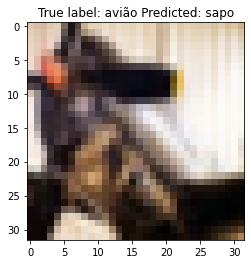

In [67]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));